In [1]:
%matplotlib inline
from matplotlib.pylab import *
import seaborn as sns
import numpy as np
from collections import defaultdict
import random

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Cell details

Each agent has several places that he goes to, including:

* His home (where he returns daily)
* His workplace (one or two)
* Places of his friends / family members (where he goes in the evening or on the weekend)
* Places where he goes to for amusement (mostly in the evening or during the weekend)
* Places where he goes for shopping (evening / weekend)

We generate a list of N places of each category. We also generate M locations

In [2]:
from collections import defaultdict
import re
import os
import numpy as np

data_directory = 'datasets/geolife/data'

user_trajectories = defaultdict(list)

def load_trajectories(data_directory):
    filenames = os.listdir(data_directory)
    for filename in filenames:
        if re.match('^\d+$',filename) and os.path.isdir(os.path.join(data_directory,filename)):
            user_id = int(filename)
            print "Loading trajectories for user {}".format(user_id)
            full_path = os.path.join(data_directory,filename,'Trajectory')
            trajectories = os.listdir(full_path)
            for trajectory_filename in trajectories:
                if trajectory_filename.endswith('.plt'):
                    with open(os.path.join(full_path,trajectory_filename),'rb') as input_file:
                        cnt = 0
                        trajectory = []
                        for line in input_file:
                            cnt+=1
                            if cnt > 6:
                                latitude,longitude,zero,alt,seconds,rest = line.strip().split(',',5)
                                latitude = float(latitude)
                                longitude = float(longitude)
                                alt = float(alt)
                                seconds = float(seconds)
                                trajectory.append((latitude,longitude,alt,seconds))
                    user_trajectories[user_id].append(np.array(trajectory))

In [3]:
load_trajectories(data_directory)

Loading trajectories for user 139
Loading trajectories for user 119
Loading trajectories for user 32
Loading trajectories for user 137
Loading trajectories for user 29
Loading trajectories for user 108
Loading trajectories for user 81
Loading trajectories for user 73
Loading trajectories for user 145
Loading trajectories for user 141
Loading trajectories for user 94
Loading trajectories for user 54
Loading trajectories for user 22
Loading trajectories for user 62
Loading trajectories for user 85
Loading trajectories for user 82
Loading trajectories for user 51
Loading trajectories for user 5
Loading trajectories for user 88
Loading trajectories for user 168
Loading trajectories for user 42
Loading trajectories for user 79
Loading trajectories for user 181
Loading trajectories for user 26
Loading trajectories for user 19
Loading trajectories for user 173
Loading trajectories for user 117
Loading trajectories for user 150
Loading trajectories for user 68
Loading trajectories for user 2
L

In [13]:
user_trajectories[0][0]

array([[    40.00769   ,    116.322383  ,    493.        ,  39774.05774306],
       [    40.007671  ,    116.322438  ,    493.        ,  39774.05780093],
       [    40.007684  ,    116.322412  ,    494.        ,  39774.0578588 ],
       ..., 
       [    39.97696   ,    116.310384  ,    453.        ,  39774.24756944],
       [    39.976905  ,    116.310328  ,    429.        ,  39774.24762731],
       [    39.976842  ,    116.310288  ,    419.        ,  39774.24768519]])

(116, 116.8)

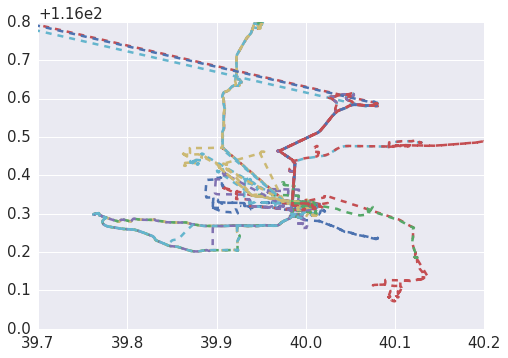

In [30]:
for trajectory in user_trajectories[0]:
    plot(trajectory[:,0],trajectory[:,1],ls = '--')
xlim(39.7,40.2)
ylim(116,116.8)

In [4]:
bounds_x = (116.,116.8)
bounds_y = (39.8,40.2)

In [5]:
import math

def is_hour_included(hour,from_hour,to_hour):
    if (from_hour is not None) and hour < from_hour:
        if to_hour and to_hour < from_hour:
            if hour > to_hour:
                return False
        else:
            return False
    if (to_hour is not None) and hour >= to_hour:
        if from_hour and from_hour > to_hour:
            if hour < from_hour:
                return False
        else:
            return False
    return True

def make_glowview_for_trajectory(trajectory, from_n = None,to_n = None,glowview = None,shape = (2000,2000),max_value = 20,bounds = (bounds_x,bounds_y),from_hour = None,to_hour = None):
    if glowview is None:
        glowview = np.zeros(shape,dtype = np.float)

    for value in trajectory[from_n:to_n]:
        pixel_y = (value[0]-bounds[1][0])/(bounds[1][1]-bounds[1][0])
        pixel_x = (value[1]-bounds[0][0])/(bounds[0][1]-bounds[0][0])
        dt = datetime.datetime(1899,12,30)+datetime.timedelta(days = value[3])

        if not is_hour_included(dt.hour,from_hour,to_hour):
            continue
        
        if (not 0 < pixel_x < 1) or (not 0 < pixel_y < 1):
            continue

        index_x,index_y = int(pixel_x*float(glowview.shape[0])),int(pixel_y*float(glowview.shape[1]))
        if max_value is None or glowview[index_x,index_y] < max_value:
            glowview[index_x,index_y]+=1.0

    return glowview

def make_glowview(user_ids,shape = (2000,2000),glowview = None,from_n = None,to_n = None,max_value = 20,n = None,bounds = (bounds_x,bounds_y),from_hour = None,to_hour = None):
    if glowview is None:
        glowview = np.zeros(shape,dtype = np.float)
    for user_id in user_ids:
        if n is None:
            n = len(user_trajectories[user_id])
        for trajectory in user_trajectories[user_id][:n]:
            make_glowview_for_trajectory(trajectory,glowview = glowview,from_n = from_n,to_n = to_n,shape = shape,max_value = max_value,bounds = bounds,from_hour = from_hour,to_hour = to_hour)
    return glowview

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


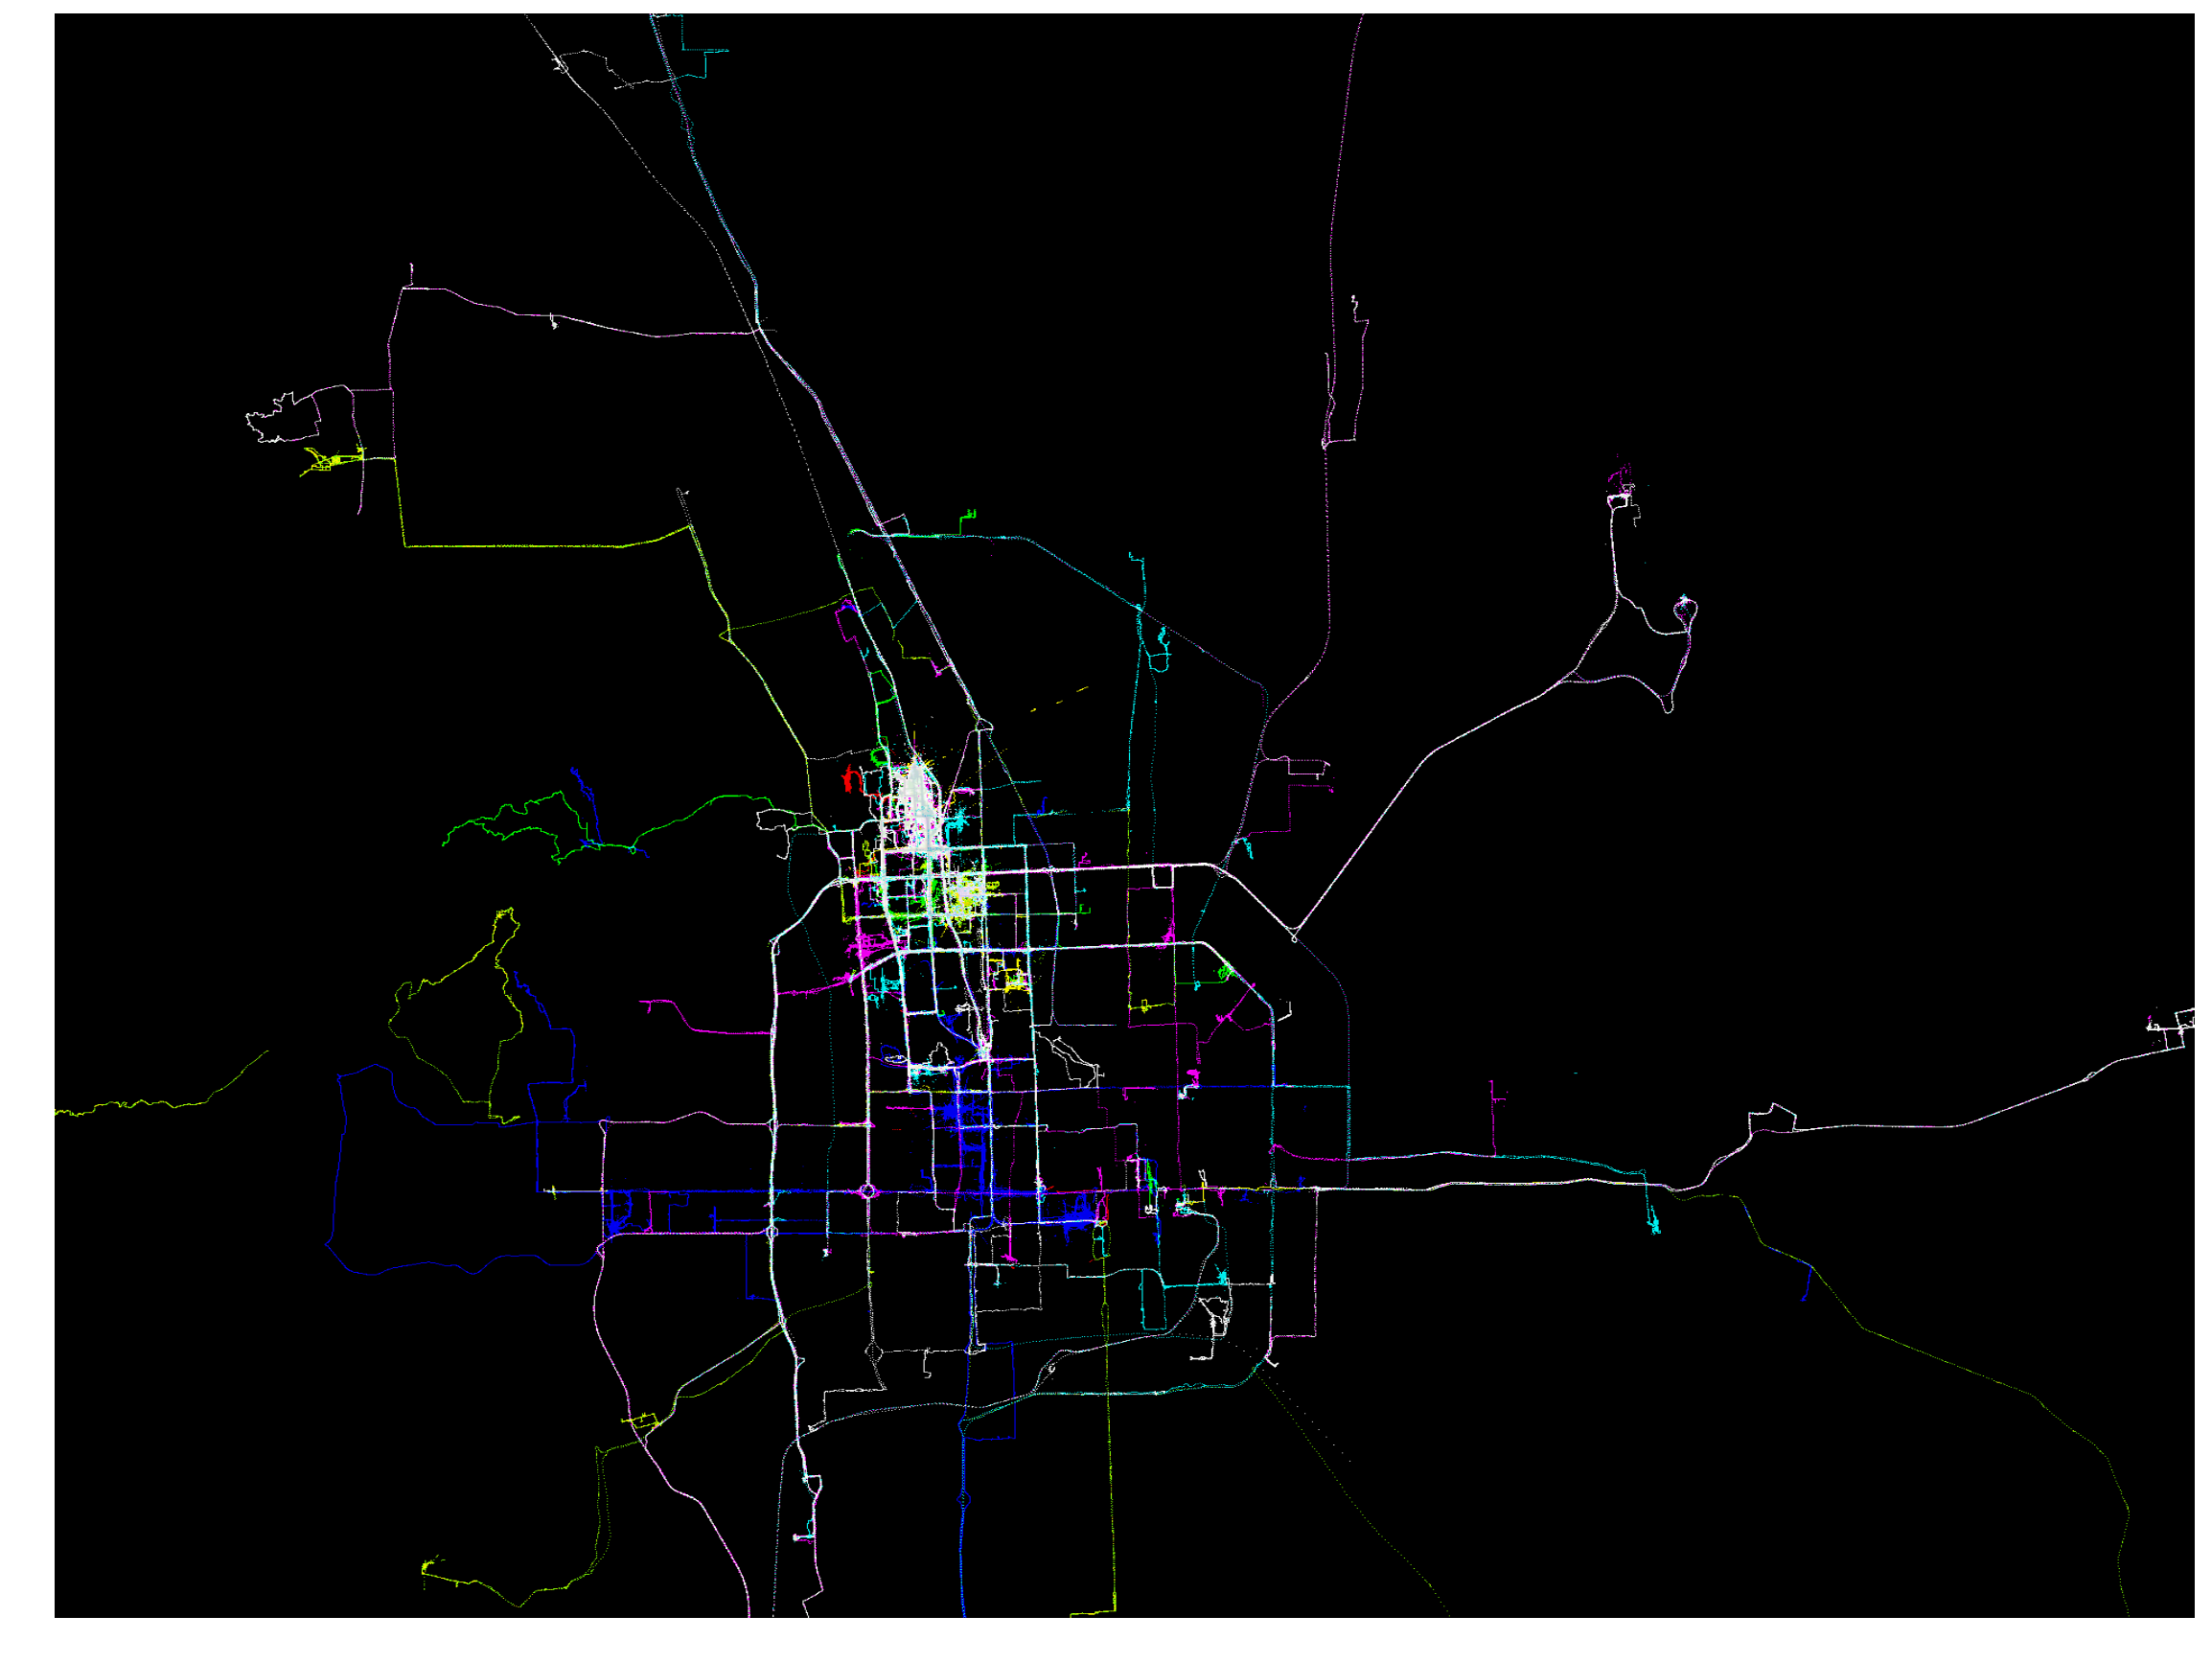

In [8]:
figure(figsize = (40,30))
i = 1
shape = (2000,2000)
glowview_rgb = np.zeros((3,shape[0],shape[1]),dtype = np.float)
maps = [(1,0,0),(0,1,0),(0,0,1),(0,1,1),(1,0,1),(1,1,0),(1,1,1),(0.5,1.0,0),(1.0,0.5,0),(0.5,0,1),(0,0.5,1),(0,1,0.5)]
i = 0
for user_id in user_trajectories.keys()[:8]:
    colormap = np.transpose(np.array(maps[i%len(maps)]))
    i+=1
    glowview = make_glowview([user_id],shape)
    for j in range(3):
        glowview_rgb[j,:,:]+= glowview*colormap[j]
grid('off')
axis('off')
imshow(np.transpose(glowview_rgb),aspect = 'auto',extent = (bounds_x[0],bounds_x[1],bounds_y[0],bounds_y[1]),origin = 'lowerleft')

In [6]:
glowview = None

In [19]:
#to make a video from the files:
#avconv -r 10 -i view_fade_%d.png -b 256k -vf "scale=1920:trunc(ow/a/2)*2" test_fade.mp4
for i in range(500,600):
    figure(figsize = (30,20))
    if glowview is not None:
        glowview*=0.97
    for j,user_id in enumerate(user_trajectories.keys()[:i+1]):
        glowview = make_glowview([user_id],glowview = glowview,from_n = (i-j)*3,to_n = (i-j+1)*3)
    grid('off')
    margins(0,0)
    gca().xaxis.set_major_locator(NullLocator())
    gca().yaxis.set_major_locator(NullLocator())
    hot()
    axis('off')
    imshow(np.transpose(glowview),aspect = 'auto',extent = (bounds_x[0],bounds_x[1],bounds_y[0],bounds_y[1]),origin = 'lowerleft')
    savefig('view_fade_very_slow_{}.png'.format(i),bbox_inches='tight',pad_inches = 0)
    close()

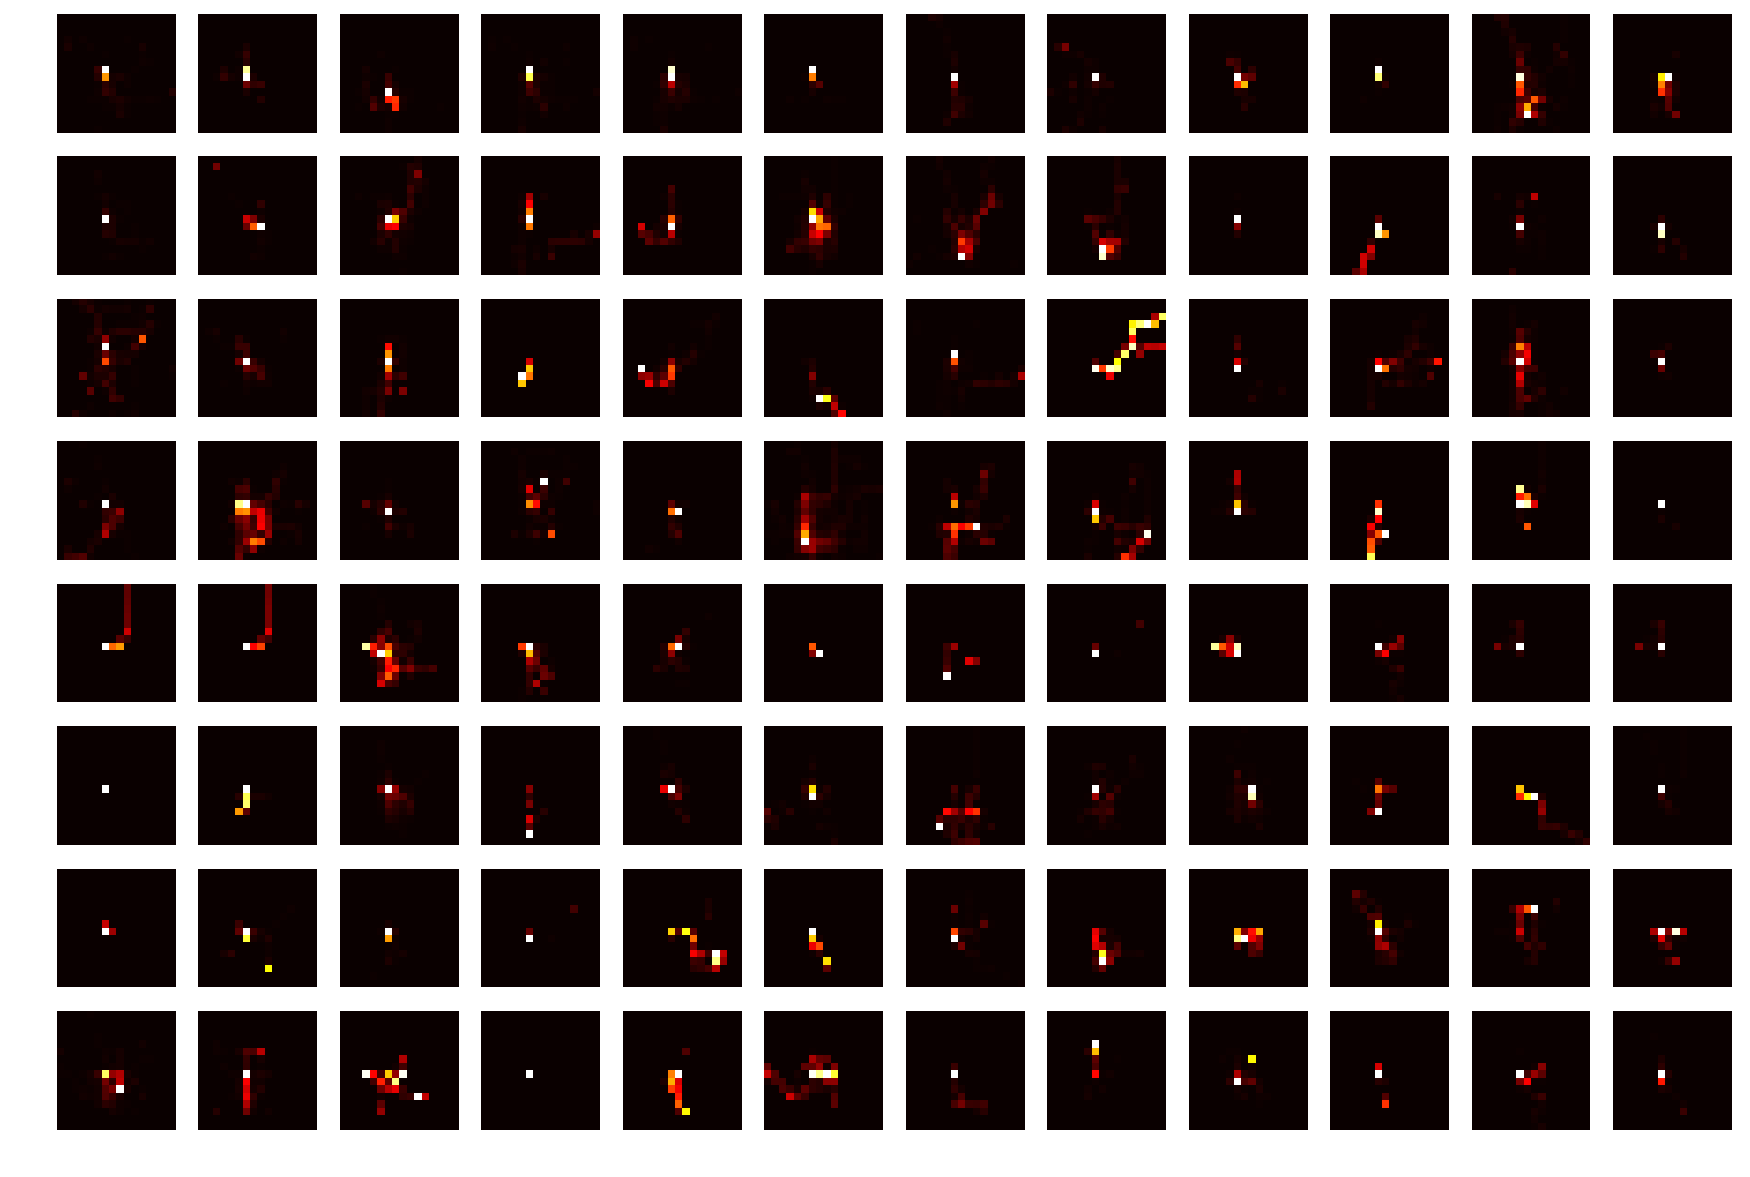

In [294]:
figure(figsize = (30,20))
shape = (16,16)
i = 0
import random
random.seed(10)
shuffled_trajectories = user_trajectories.keys()
for user_id in shuffled_trajectories[:12*8]:
    colormap = np.transpose(np.array(maps[i%len(maps)]))
    i+=1
    subplot(8,12,i)
    glowview = make_glowview([user_id],shape,max_value = None)
    grid('off')
    axis('off')
    imshow(np.transpose(glowview),interpolation = 'nearest',aspect = 'auto',extent = (bounds_x[0],bounds_x[1],bounds_y[0],bounds_y[1]),origin = 'lowerleft')

In [7]:
best_uids = defaultdict(dict)
user_ranks = defaultdict(dict)

In [8]:
shape = (16,16)
n_tiles = shape[0]*shape[1]
user_fingerprints = {}
f_training = 3/4.
for user_id in user_trajectories.keys():
    glowview = make_glowview([user_id],shape,max_value = None,n = int(len(user_trajectories[user_id])*f_training))
    user_fingerprints[user_id] = glowview/np.max(glowview)

In [20]:
for uid in user_fingerprints.keys():
    fingerprints = [make_glowview_for_trajectory(trajectory,shape = shape,max_value = None) for trajectory in user_trajectories[uid][int(len(user_trajectories[uid])*f_training):]]

    for fingerprint in fingerprints:
        if np.max(fingerprint):
            fingerprint/=np.max(fingerprint)

    user_ids = []
    scores = []
    best_score = None
    best_uid = None
    true_user_score = None
    for user_id,fingerprint in user_fingerprints.items():
        if not np.any(fingerprint):
            continue
        score = reduce(lambda x,y:x+y,[np.sum(fp*fingerprint) for fp in fingerprints])
        if best_score is None or score > best_score:
            best_uid = user_id
            best_score = score
        if user_id == uid:
            true_user_score = score
        user_ids.append(user_id)
        scores.append(score)
    user_ranks[n_tiles][uid] = len([score for score in scores if score > true_user_score])
    best_uids[n_tiles][uid] = best_uid

#plot(user_ids,scores,ls = '',marker = 'o')
#axvline(uid,color = 'grey',ls = '--')
#axhline(scores[uid],color = 'grey',ls = '--')

In [14]:
sum([1 for user_id,best_user_id in best_uids[1024].items() if user_id == best_user_id])*1.0/len(best_uids)
#16: 4 %
#256: 23 %
#1024: 20 %

58.0

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


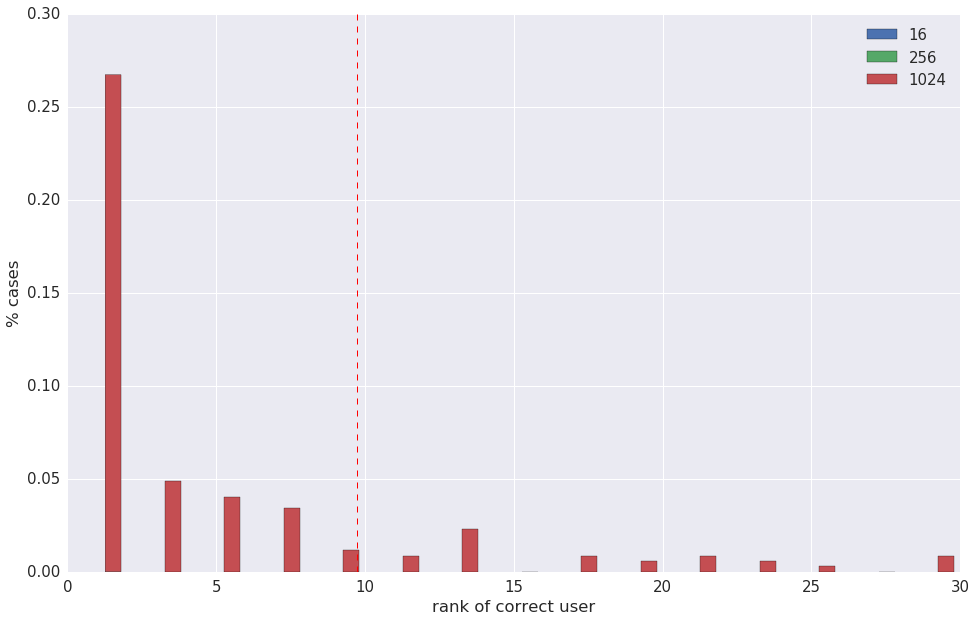

In [15]:
figure(figsize = (16,10))
legends = []

nts = [16,256,1024]
hist([user_ranks[nt].values() for nt in nts],bins = 30,range=(0,60),normed = True)
legend(nts)
colors = ['blue','green','red']
for color,nt in zip(colors,nts):
    axvline(np.mean(user_ranks[nt].values()),ls = '--',lw = '1',color = color)
xlim(right = 30,left=0)
ylabel("% cases")
xlabel("rank of correct user")
#semilogy()


In [16]:
np.mean(user_ranks[1024].values())

9.719780219780219

In [352]:
del user_ranks[32]

In [72]:
similarities = np.zeros((len(user_fingerprints),len(user_fingerprints)))
for user_a_id,user_a_fingerprint in user_fingerprints.items():
    for user_b_id,user_b_fingerprint in user_fingerprints.items():
        if user_a_id == user_b_id:
            continue
        if np.isnan(user_a_fingerprint[0,0]) or np.isnan(user_b_fingerprint[0,0]):
            continue
        if similarities[user_a_id,user_b_id]:
            continue
        similarities[user_a_id,user_b_id] = np.sum(user_a_fingerprint*user_b_fingerprint)

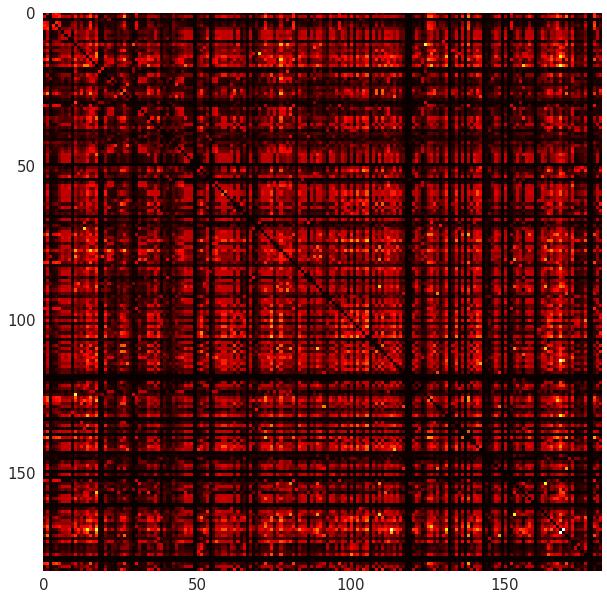

In [423]:
figure(figsize = (16,10))
hot()
imshow(similarities,interpolation = 'nearest')
grid('off')

In [113]:
max_ind = np.argsort(np.reshape(similarities,(similarities.shape[0]**2,)))
i = 3
ix = max_ind[-i]/similarities.shape[0]
iy = max_ind[-i]%similarities.shape[0]
similarities[ix,iy]

3.5537640235700403

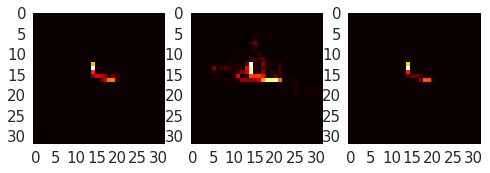

In [114]:
subplot(131)
grid('off')
imshow(user_fingerprints[ix],interpolation = 'nearest')
subplot(132)
grid('off')
imshow(user_fingerprints[iy],interpolation = 'nearest')
subplot(133)
grid('off')
imshow(user_fingerprints[ix]*user_fingerprints[iy],interpolation = 'nearest')


In [21]:
np.sum(user_fingerprints[ix]*user_fingerprints[iy])/np.sum(user_fingerprints[ix])/np.sum(user_fingerprints[iy]),similarities[ix,iy]

(0.80178490343573916, 0.80178490343573916)

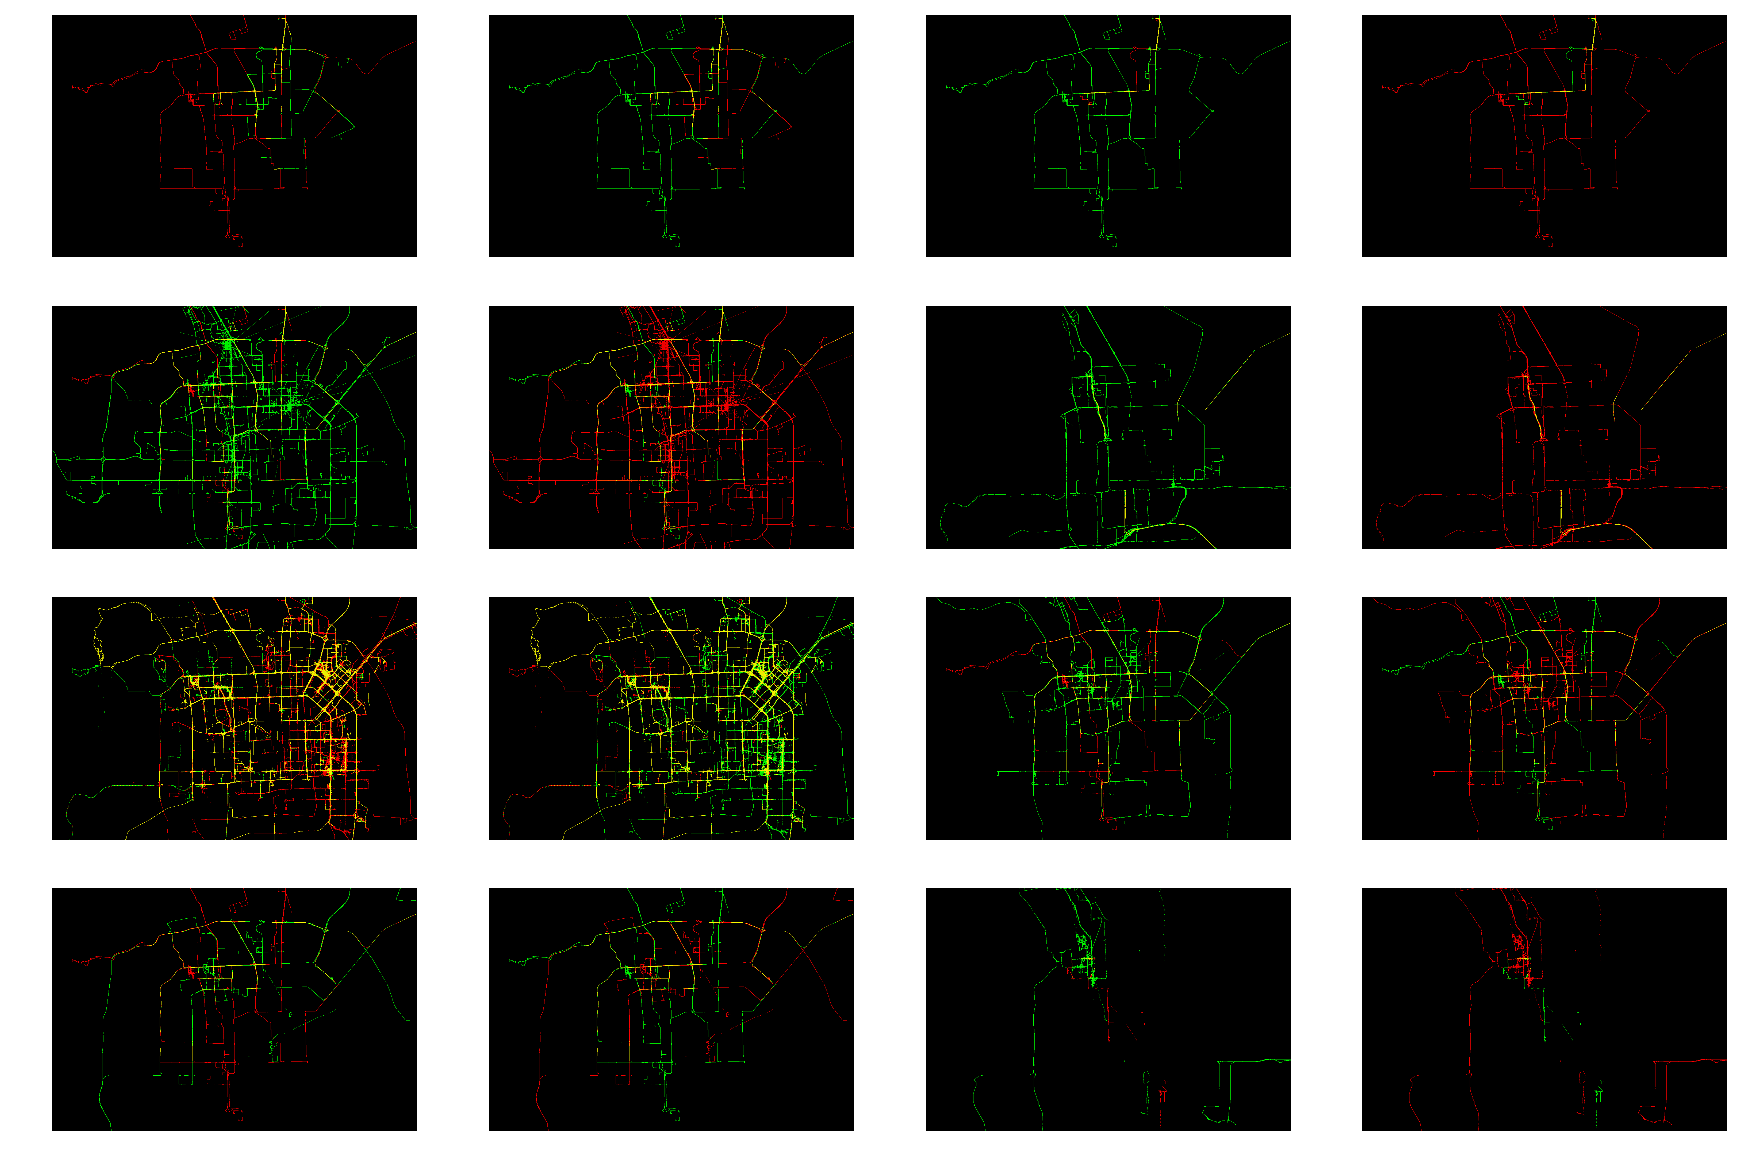

In [155]:
figure(figsize = (30,20))
i = 1
shape = (1000,1000)
bounds =((116.15,116.55),(39.85,40.05))
for i in range(1,17):
    subplot(4,4,i)
    ix = max_ind[-i]/similarities.shape[0]
    iy = max_ind[-i]%similarities.shape[0]

    glowview_rgb = np.zeros((3,shape[0],shape[1]),dtype = np.float)
    maps = [(1,0,0),(0,1,0),(0,0,1),(0,1,1),(1,0,1),(1,1,0),(1,1,1),(0.5,1.0,0),(1.0,0.5,0),(0.5,0,1),(0,0.5,1),(0,1,0.5)]
    i = 0
    for user_id in [ix,iy]:
        colormap = np.transpose(np.array(maps[i%len(maps)]))
        i+=1
        glowview = make_glowview([user_id],shape,bounds = bounds)
        for j in range(3):
            glowview_rgb[j,:,:]+= glowview*colormap[j]
    grid('off')
    axis('off')
    imshow(np.transpose(glowview_rgb),aspect = 'auto',origin = 'lowerleft')

In [197]:
import datetime
(datetime.datetime(1899,12,30)+datetime.timedelta(days = user_trajectories[0][0][176][3])).hour

1

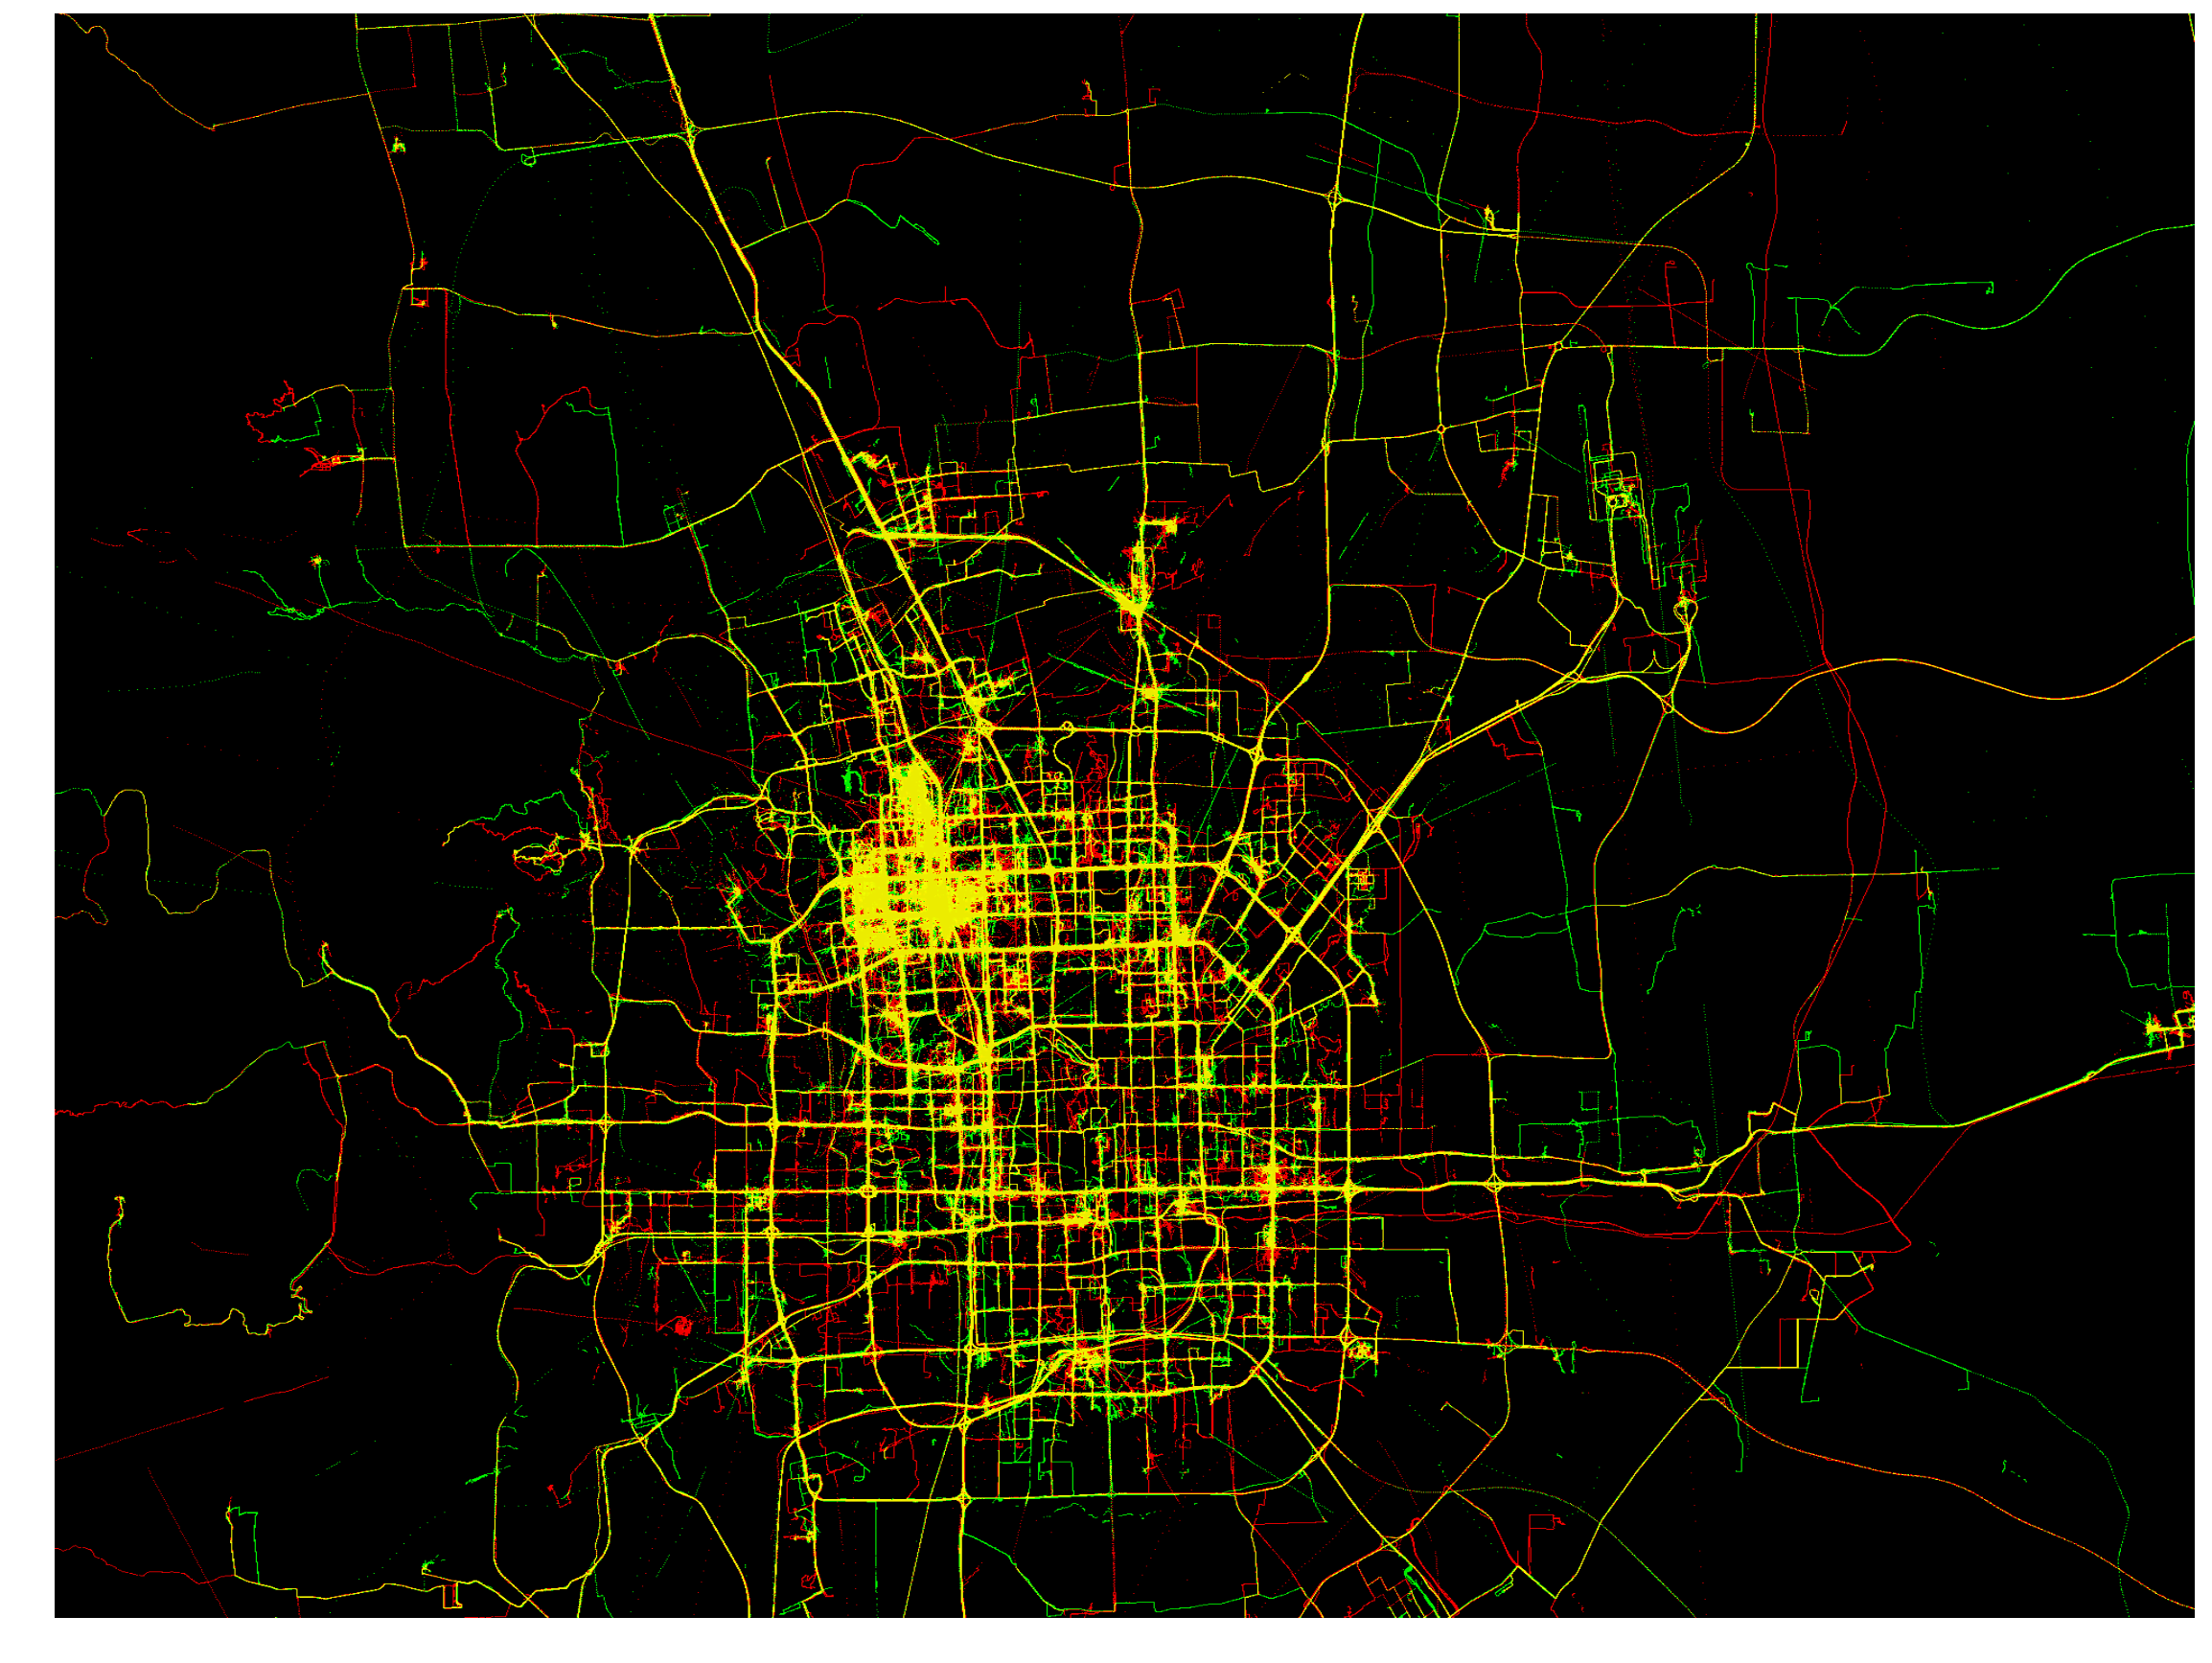

In [267]:
figure(figsize = (40,30))
i = 1
shape = (2000,2000)
glowview_rgb = np.zeros((3,shape[0],shape[1]),dtype = np.float)
maps = [(1,0,0),(0,1,0)]
i = 0
for from_hour,to_hour in ((6,18),(18,6)):
    colormap = np.transpose(np.array(maps[i%len(maps)]))
    i+=1
    glowview = make_glowview(user_trajectories.keys(),shape,from_hour = from_hour,to_hour = to_hour)
    for j in range(3):
        glowview_rgb[j,:,:]+= glowview*colormap[j]
grid('off')
axis('off')
imshow(np.transpose(glowview_rgb),aspect = 'auto',extent = (bounds_x[0],bounds_x[1],bounds_y[0],bounds_y[1]),origin = 'lowerleft')

In [293]:
shape = (16,16)
n_tiles = shape[0]*shape[1]
unnormalized_fingerprints = {}
f_training = 3/4.
for user_id in user_trajectories.keys():
    glowview = make_glowview([user_id],shape,max_value = None,n = int(len(user_trajectories[user_id])*f_training))
    unnormalized_fingerprints[user_id] = glowview

In [294]:
frequencies = np.zeros(shape,dtype = np.int)

for fingerprint in unnormalized_fingerprints.values():
    frequencies+=(fingerprint).astype(np.int)

(-0.5, 15.5, 15.5, -0.5)

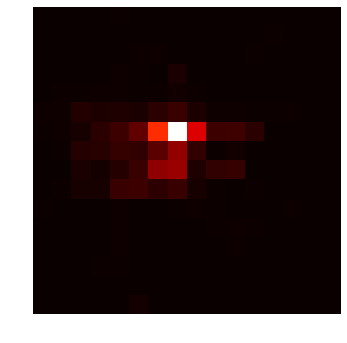

In [297]:
imshow(frequencies,interpolation = 'nearest')
grid('off')
axis('off')

In [347]:
values = np.sort(np.reshape(frequencies,(frequencies.shape[0]**2,)))

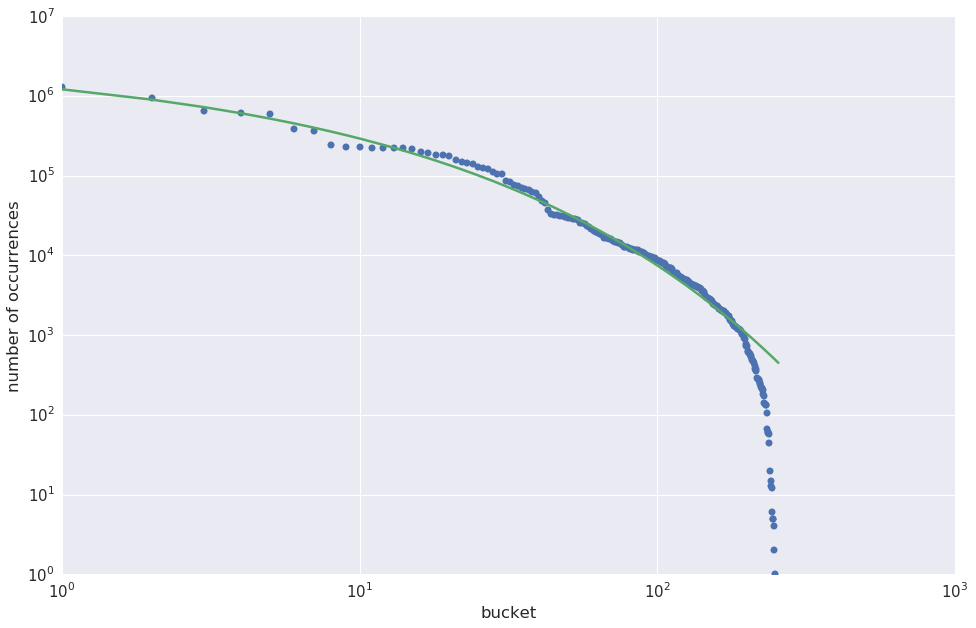

In [419]:
figure(figsize = (16,10))
xs = np.arange(0,256)
ys = values[::-1]
plot(xs,ys,marker = 'o',ls = '')
plot(xs,fx(ps.x,xs))
loglog()
ylabel("number of occurrences")
xlabel("bucket")

In [416]:
def fx(p,xs):
    return np.exp(-(xs**p[0])*p[1])*p[2]

def f(p):
    return np.sum(np.power(fx(p,xs)-ys,2))

In [418]:
from scipy.optimize import minimize

ps = minimize(f,[1.0,0.1,1e6],method = 'Powell',tol = 1e-10)
print ps.x

[  4.10938641e-01   9.03073755e-01   2.99429687e+06]


In [408]:
f([0.7,0.1,1e6])

13724977663881.029

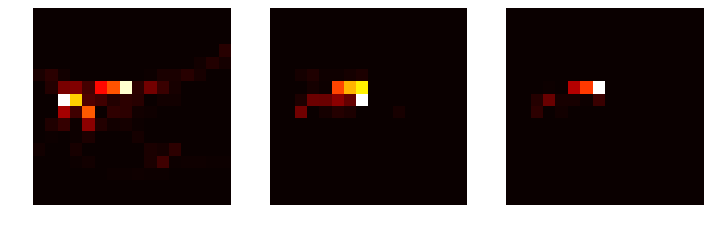

In [19]:
figure(figsize = (12,6))
hot()
axis('off')
grid('off')
subplot(131)
axis('off')
grid('off')
imshow(user_fingerprints[10],interpolation = 'nearest')
subplot(132)
axis('off')
grid('off')
imshow(user_fingerprints[11],interpolation = 'nearest')
subplot(133)
axis('off')
grid('off')
imshow(user_fingerprints[11]*user_fingerprints[10],interpolation = 'nearest')